In [38]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import numpy as np
import pickle

sys.path.append('D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin')
from models import *
from clients_datasets import *
from tqdm.notebook import tqdm
from utils import *
from AttFunc import *
from Fisher_LeNet import *

In [39]:
batch_size = 600
epochs = 30
NC = 10
dataset = 'mnist'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 4

criterion = torch.nn.CrossEntropyLoss()

In [18]:
am = LeNet_5().cuda()
am_train(am, clients_trainloader[8], dataset)

att_type = 'unit'
acc0 = 98.88
betas = []

for i in range(10):
    beta = simulated_annealing(dataset, 1, 500, att_type, acc0,  clients_testloader[8])
    betas.append(beta)
    print(beta)
beta_mean, beta_range = data_process(betas)
print('-------------------------------------')
print(beta_mean)

Training attack model:   0%|          | 0/100 [00:00<?, ?eopch/s]

0.4712197590621049
1.092358243723927
1.1038428402018607
1.00467112461954
1.572437922762433
0.7259892176235456
0.8234427502769143
1.4116702324011752
1.185832366595279
0.871120614608052
-------------------------------------
1.0669574028484423


In [40]:
alpha = [0.2, 0.4, 0.6, 0.8]
alpha = [0.1, 0.3, 0.5, 0.7, 0.9]

In [41]:
acc0 = 98.88
att_type = 'unit'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 5
mode = 'Basic'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'mnist'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 4

    criterion = torch.nn.CrossEntropyLoss()
    # train
    mal_client_id = [8]
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id:
                benign_params = list(client.parameters())[:2]
                mal_params = perturbation(beta=beta, bp=benign_params, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

basic_acc1=acc1_varying
print(acc1_varying)
print(drop_varying)

Training:   0%|          | 0/5 [00:00<?, ?iter/s]

[97.61999999999999, 97.18, 97.11999999999999, 97.35999999999999, 97.48200000000001]
[1.2599999999999938, 1.6999999999999935, 1.7599999999999938, 1.5199999999999942, 1.3979999999999941]


In [61]:
acc0 = 98.88
att_type = 'unit'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 5
mode = 'Fisher'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'mnist'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 4

    criterion = torch.nn.CrossEntropyLoss()
    # train
    mal_client_id = [8]
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id :
                benign_params = list(client.parameters())[:2]

                fisher_matrix = {}
                for param_name, param in client.named_parameters():
                    if param_name == 'conv1.0.weight':
                        grad = param.grad.cpu().detach().numpy()
                        if param_name not in fisher_matrix:
                            fisher_matrix[param_name] = grad ** 2
                        else:
                            fisher_matrix[param_name] += grad ** 2
                    if param_name == 'conv1.0.bias':
                        grad = param.grad.cpu().detach().numpy()
                        if param_name not in fisher_matrix:
                            fisher_matrix[param_name] = grad ** 2
                        else:
                            fisher_matrix[param_name] += grad ** 2
                weight_positions = []
                bias_positions = []
                weight_positions.append(find_positions(fisher_matrix['conv1.0.weight'], alpha[iter]))
                bias_positions.append(find_positions(fisher_matrix['conv1.0.bias'], alpha[iter]))

                mal_params = fisher_perturbation(client_level, beta, benign_params, weight_positions, bias_positions, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

fisher_acc1=acc1_varying
print(acc1_varying)
print(drop_varying)

Training:   0%|          | 0/5 [00:00<?, ?iter/s]

[88.97, 90.91999999999999, 91.87333333333335, 90.96000000000001, 90.14200000000001]
[9.909999999999997, 7.959999999999998, 7.006666666666663, 7.919999999999996, 8.737999999999994]


In [43]:
acc0 = 98.88
att_type = 'unit'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 5
mode = 'Taylor'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'mnist'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 4

    criterion = torch.nn.CrossEntropyLoss()
    # train
    mal_client_id = [8]
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id:
                benign_params = list(client.parameters())[:2]

                Taylor_scores = {}
                for param_name, param in client.named_parameters():
                    if param.grad is not None:
                        Taylor_scores[param_name] = torch.abs(param * param.grad)

                weight_positions = []
                bias_positions = []
                weight_positions.append(find_positions(Taylor_scores['conv1.0.weight'].cpu().detach().numpy(), alpha[iter]))
                bias_positions.append(find_positions(Taylor_scores['conv1.0.bias'].cpu().detach().numpy(), alpha[iter]))

                mal_params = fisher_perturbation(client_level, beta, benign_params, weight_positions, bias_positions, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

taylor_acc1=acc1_varying
print(acc1_varying)
print(drop_varying)

Training:   0%|          | 0/5 [00:00<?, ?iter/s]

[87.38000000000001, 84.00500000000001, 86.85333333333334, 87.37, 84.97399999999999]
[11.499999999999996, 14.874999999999995, 12.026666666666662, 11.509999999999994, 13.905999999999995]


In [37]:
baseline = [98.88] * 5
basic_acc1 = [97.74999999999999, 97.1, 97.54666666666665, 97.29499999999999]
fisher_acc1 = [92.59, 90.02, 92.21, 91.14000000000001]
taylor_acc1 = [90.38000000000001, 89.635, 89.07, 90.9675]

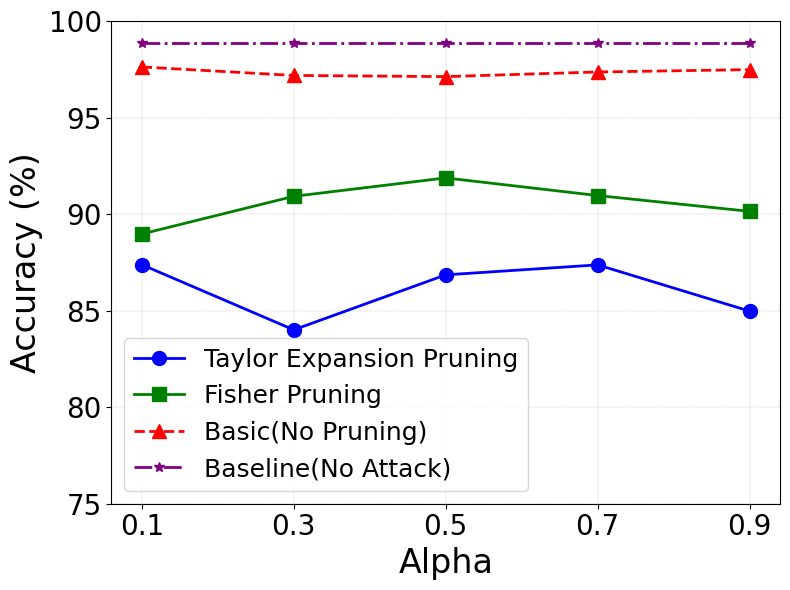

In [64]:
baseline = [98.88] * 5

plt.figure(figsize=(8, 6))
plt.plot(alpha, taylor_acc1, marker='o', markersize=10, label='Taylor Expansion Pruning', color='blue', linestyle='-', linewidth=2)
plt.plot(alpha, fisher_acc1, marker='s', markersize=10, label='Fisher Pruning', color='green', linestyle='-', linewidth=2)
plt.plot(alpha, basic_acc1, marker='^', markersize=10, label='Basic(No Pruning)', color='red', linestyle='--', linewidth=2)
plt.plot(alpha, baseline, marker='*', markersize=7, label='Baseline(No Attack)', color='purple', linestyle='-.', linewidth=2)

plt.xticks(alpha, fontsize=20)  # Mark all client IDs
plt.yticks(fontsize=20)
plt.xlabel('Alpha', fontsize=24)
plt.ylabel('Accuracy (%)', fontsize=24)
plt.ylim(75, 100)
plt.legend(fontsize=18)

plt.grid(True, linestyle=':', linewidth=0.3, color='gray')
plt.tight_layout()
plt.show()